In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

In [2]:
df = pd.read_csv("../data/raw/Titanic-Dataset.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Modificación del dataset para facilitar su lectura

In [4]:
# Estadísticas para revisar posibles combinaciones de factores que juegan un papel clave para los datos

df['TamañoFamilia'] = df['SibSp'] + df['Parch'] + 1  # Tamaño de la familia dentro del barco
df["OrigenClase3"] = (df['Pclass'] == 3).astype(int) # Creación de variable binaria para una mejor interpretación
df["OrigenEmbarked_Southampton"] = (df['Embarked'] == 'S').astype(int)

In [5]:
subgrupo1 = (df["OrigenClase3"] == 1) & (df["OrigenEmbarked_Southampton"] == 1) # Creación del subgrupo que respeta las combinanciones anteriores
df['Categorias_Familia'] = pd.cut(df['TamañoFamilia'], bins=[0,1,3,6,100], labels=['1','2-3','4-6','7+']) # Categorías de familia con etiquetas
print("Total de Pasajeros de Tercera & Southampton por Familia :", df[subgrupo1].shape[0])
print("Distribución (Tercera Clase & Southampton por Tamaño de Familia):")
print(df[subgrupo1]['Categorias_Familia'].value_counts(dropna=False))

Total de Pasajeros de Tercera & Southampton por Familia : 353
Distribución (Tercera Clase & Southampton por Tamaño de Familia):
Categorias_Familia
1      232
2-3     67
4-6     29
7+      25
Name: count, dtype: int64


## Hipótesis 1: Los pasajeros con hijos menores de edad tuvieron mayor probabilidad de supervivencia que los pasajeros sin hijos menores de edad.


In [6]:
df[subgrupo1].groupby('Categorias_Familia')['Survived'].agg(['count','mean']).rename(columns={'mean':'Supervivencia'})


/var/folders/0l/1v0zpypj6wj_fr86w3yq14x00000gn/T/ipykernel_29885/2412730589.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[subgrupo1].groupby('Categorias_Familia')['Survived'].agg(['count','mean']).rename(columns={'mean':'Supervivencia'})


,count,Supervivencia
Categorias_Familia,,
1,232,0.168103
2-3,67,0.328358
4-6,29,0.068966
7+,25,0.160000


/var/folders/0l/1v0zpypj6wj_fr86w3yq14x00000gn/T/ipykernel_29885/3542318626.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_rate_subgrupo1 = df[subgrupo1].groupby('Categorias_Familia')['Survived'].mean().reset_index()
/var/folders/0l/1v0zpypj6wj_fr86w3yq14x00000gn/T/ipykernel_29885/3542318626.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=survival_rate_subgrupo1, x='Categorias_Familia', y='Survived', palette='viridis')


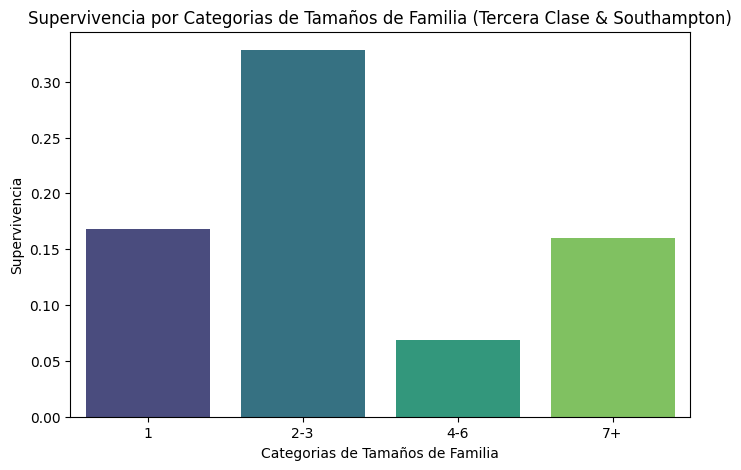

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Se calcula la supervivencia por el subgrupo de categorias de tamaños de familia
survival_rate_subgrupo1 = df[subgrupo1].groupby('Categorias_Familia')['Survived'].mean().reset_index()

# Se crea un boxplot
plt.figure(figsize=(8, 5))
sns.barplot(data=survival_rate_subgrupo1, x='Categorias_Familia', y='Survived', palette='viridis')

# Add titles and labels
plt.title('Supervivencia por Categorias de Tamaños de Familia (Tercera Clase & Southampton)')
plt.xlabel('Categorias de Tamaños de Familia')
plt.ylabel('Supervivencia')

# Desplegar gráfica
plt.show()


In [8]:
#%pip install statsmodels
import statsmodels.api as sm

# Variables independieentes y variable dependiente
vars_i = df[[ "TamañoFamilia", "OrigenClase3", "OrigenEmbarked_Southampton"]]
var_d = df["Survived"]

# Agregamos una constante (intercepto)
vars_i = sm.add_constant(vars_i)

# Ajustamos el modelo de regresión logística
logit_model = sm.Logit(var_d, vars_i).fit()


# Resumen de resultados
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.597779
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      887
Method:                           MLE   Df Model:                            3
Date:                Sat, 13 Sep 2025   Pseudo R-squ.:                  0.1023
Time:                        20:18:17   Log-Likelihood:                -532.62
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 3.830e-26
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.7061      0.174      4.047      0.000      

## Hipótesis 2: a probabilidad de supervivencia en primera clase es al menos 50% mejor que la de tercera clase, para todas las edades y géneros

In [9]:
# MANTENEMOS SOLO LAS CLASES 1 Y 3 PARA EL ANÁLISIS
df_hipotesis2 = df[df['Pclass'].isin([1, 3])].copy()

In [10]:
media_edad = df_hipotesis2['Age'].mean()
df_hipotesis2['Age'] = df_hipotesis2['Age'].fillna(media_edad)

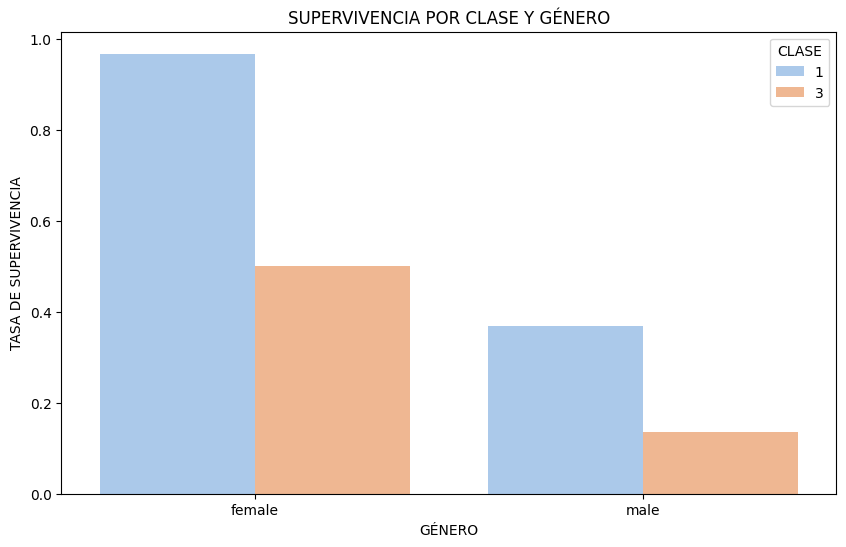

In [11]:
# --- 1. ANÁLISIS VISUAL PARA SUBGRUPOS (GÉNERO Y CLASE) ---

# CALCULAMOS LA TASA DE SUPERVIVENCIA POR GÉNERO Y CLASE
survival_rate_gender_class = df_hipotesis2.groupby(['Sex', 'Pclass'])['Survived'].mean().reset_index()

# CREAMOS UNA GRÁFICA DE BARRAS
plt.figure(figsize=(10, 6))
sns.barplot(
    data=survival_rate_gender_class,
    x='Sex',
    y='Survived',
    hue='Pclass',
    palette='pastel'
)

plt.title('SUPERVIVENCIA POR CLASE Y GÉNERO')
plt.xlabel('GÉNERO')
plt.ylabel('TASA DE SUPERVIVENCIA')
plt.legend(title='CLASE', loc='upper right')
plt.show()

In [12]:
# --- 2. MODELO DE REGRESIÓN LOGÍSTICA PARA EL ANÁLISIS PRINCIPAL ---

# VARIABLE DEPENDIENTE: Supervivencia
var_d = df_hipotesis2["Survived"]

# VARIABLES INDEPENDIENTES: Pclass, Sex y Age
# PCLASS: CONVERTIMOS LA CLASE 1 EN DUMMY (1 SI ES CLASE 1, 0 SI ES CLASE 3)
df_hipotesis2['Pclass_1'] = np.where(df_hipotesis2['Pclass'] == 1, 1, 0)

# SEX: CONVERTIMOS EL GÉNERO EN DUMMY (1 SI ES HOMBRE, 0 SI ES MUJER)
df_hipotesis2['Sex_male'] = np.where(df_hipotesis2['Sex'] == 'male', 1, 0)

# SELECCIONAMOS LAS VARIABLES PARA EL MODELO
vars_i = df_hipotesis2[['Pclass_1', 'Sex_male', 'Age']]

# AGREGAMOS UNA CONSTANTE (INTERCEPTO)
vars_i = sm.add_constant(vars_i)

# AJUSTAMOS EL MODELO DE REGRESIÓN LOGÍSTICA
logit_model = sm.Logit(var_d, vars_i).fit()

print("\n--- RESUMEN DE LA REGRESIÓN LOGÍSTICA ---")
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.470919
         Iterations 6

--- RESUMEN DE LA REGRESIÓN LOGÍSTICA ---
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  707
Model:                          Logit   Df Residuals:                      703
Method:                           MLE   Df Model:                            3
Date:                Sat, 13 Sep 2025   Pseudo R-squ.:                  0.2797
Time:                        20:18:17   Log-Likelihood:                -332.94
converged:                       True   LL-Null:                       -462.24
Covariance Type:            nonrobust   LLR p-value:                 9.008e-56
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8597      0.254      3.380      0.001       0.36

In [13]:
# --- 3. EVALUACIÓN DE LA HIPÓTESIS ---

print("\n--- CRITERIOS DE DECISIÓN (ANÁLISIS PRINCIPAL) ---")
# OBTENEMOS EL ODDS RATIO PARA LA VARIABLE 'Pclass_1'
odds_ratio_pclass = np.exp(logit_model.params['Pclass_1'])
p_value_pclass = logit_model.pvalues['Pclass_1']

print(f"VALOR P PARA PCLASS_1: {p_value_pclass:.4f}")
print(f"ODDS RATIO PARA PCLASS_1: {odds_ratio_pclass:.2f}")

# VERIFICAMOS LA SIGNIFICANCIA ESTADÍSTICA Y EL TAMAÑO DEL EFECTO
if p_value_pclass < 0.05:
    print("LA VARIABLE 'PCLASS' ES ESTADÍSTICAMENTE SIGNIFICATIVA.")
    if odds_ratio_pclass >= 1.5:
        print("EL ODDS RATIO ES MAYOR O IGUAL A 1.5.")
        print("ESTE ANÁLISIS APOYA LA HIPÓTESIS PRINCIPAL.")
    else:
        print("EL ODDS RATIO ES MENOR A 1.5.")
        print("LA HIPÓTESIS NO SE CUMPLE CON EL TAMAÑO DE EFECTO MÍNIMO REQUERIDO.")
else:
    print("LA VARIABLE 'PCLASS' NO ES ESTADÍSTICAMENTE SIGNIFICATIVA.")
    print("NO HAY EVIDENCIA PARA APOYAR LA HIPÓTESIS PRINCIPAL.")


--- CRITERIOS DE DECISIÓN (ANÁLISIS PRINCIPAL) ---
VALOR P PARA PCLASS_1: 0.0000
ODDS RATIO PARA PCLASS_1: 8.38
LA VARIABLE 'PCLASS' ES ESTADÍSTICAMENTE SIGNIFICATIVA.
EL ODDS RATIO ES MAYOR O IGUAL A 1.5.
ESTE ANÁLISIS APOYA LA HIPÓTESIS PRINCIPAL.


In [14]:
# --- 4. ANÁLISIS DE SUBGRUPOS (REGRESIÓN LOGÍSTICA POR GÉNERO) ---

# SUBGRUPO: MUJERES
print("\n--- SUBGRUPO: MUJERES ---")
df_mujeres = df_hipotesis2[df_hipotesis2['Sex_male'] == 0].copy()
if not df_mujeres.empty:
    vars_i_mujeres = df_mujeres[['Pclass_1', 'Age']]
    var_d_mujeres = df_mujeres['Survived']
    vars_i_mujeres = sm.add_constant(vars_i_mujeres)
    try:
        modelo_mujeres = sm.Logit(var_d_mujeres, vars_i_mujeres).fit()
        odds_ratio_mujeres = np.exp(modelo_mujeres.params['Pclass_1'])
        p_value_mujeres = modelo_mujeres.pvalues['Pclass_1']

        print(f"ODDS RATIO PARA MUJERES: {odds_ratio_mujeres:.2f}")
        print(f"VALOR P PARA MUJERES: {p_value_mujeres:.4f}")

        if p_value_mujeres < 0.05 and odds_ratio_mujeres >= 1.5:
            print("LA HIPÓTESIS SE CUMPLE EN EL SUBGRUPO DE MUJERES.")
        else:
            print("LA HIPÓTESIS NO SE CUMPLE EN EL SUBGRUPO DE MUJERES.")
    except Exception as e:
        print(f"ERROR AL AJUSTAR EL MODELO PARA MUJERES: {e}")
else:
    print("NO HAY DATOS EN EL SUBGRUPO DE MUJERES.")


# SUBGRUPO: HOMBRES
print("\n--- SUBGRUPO: HOMBRES ---")
df_hombres = df_hipotesis2[df_hipotesis2['Sex_male'] == 1].copy()
if not df_hombres.empty:
    vars_i_hombres = df_hombres[['Pclass_1', 'Age']]
    var_d_hombres = df_hombres['Survived']
    vars_i_hombres = sm.add_constant(vars_i_hombres)
    try:
        modelo_hombres = sm.Logit(var_d_hombres, vars_i_hombres).fit()
        odds_ratio_hombres = np.exp(modelo_hombres.params['Pclass_1'])
        p_value_hombres = modelo_hombres.pvalues['Pclass_1']

        print(f"ODDS RATIO PARA HOMBRES: {odds_ratio_hombres:.2f}")
        print(f"VALOR P PARA HOMBRES: {p_value_hombres:.4f}")

        if p_value_hombres < 0.05 and odds_ratio_hombres >= 1.5:
            print("LA HIPÓTESIS SE CUMPLE EN EL SUBGRUPO DE HOMBRES.")
        else:
            print("LA HIPÓTESIS NO SE CUMPLE EN EL SUBGRUPO DE HOMBRES.")
    except Exception as e:
        print(f"ERROR AL AJUSTAR EL MODELO PARA HOMBRES: {e}")
else:
    print("NO HAY DATOS EN EL SUBGRUPO DE HOMBRES.")


--- SUBGRUPO: MUJERES ---
Optimization terminated successfully.
         Current function value: 0.473861
         Iterations 7
ODDS RATIO PARA MUJERES: 34.33
VALOR P PARA MUJERES: 0.0000
LA HIPÓTESIS SE CUMPLE EN EL SUBGRUPO DE MUJERES.

--- SUBGRUPO: HOMBRES ---
Optimization terminated successfully.
         Current function value: 0.452136
         Iterations 6
ODDS RATIO PARA HOMBRES: 5.76
VALOR P PARA HOMBRES: 0.0000
LA HIPÓTESIS SE CUMPLE EN EL SUBGRUPO DE HOMBRES.


## Hipótesis 3: La posibilidad de supervivencia disminuye en cuestión de ser de tercera vinculados a varios familiares provenientes de Southampton


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Cargamos el dataset (asumiendo que 'df' ya está cargado)

# Manejamos de valores nulos para las variables clave
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Fare'].fillna(df['Fare'].mean(), inplace=True)

# Creamos la variable 'FamilySize' (tamaño de la familia)
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Convertimos las variables categóricas a dummies (one-hot encoding)
df = pd.get_dummies(df, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True, dtype=int)

# Creamos la variable de interacción de la Hipótesis 3
# Esta variable es 1 si el pasajero es de 3ª clase, viaja en familia (más de 1 persona) y embarcó en Southampton (Embarked_S)
df['Hipotesis3_Interaction'] = np.where(
    (df['Pclass_3'] == 1) & 
    (df['FamilySize'] > 1) & 
    (df['Embarked_S'] == 1),
    1,
    0
)

# Verificamos el conteo de la nueva variable
print("Conteo de la nueva variable de interacción 'Hipotesis3_Interaction':")
print(df['Hipotesis3_Interaction'].value_counts())

Conteo de la nueva variable de interacción 'Hipotesis3_Interaction':
Hipotesis3_Interaction
0    770
1    121
Name: count, dtype: int64


/var/folders/0l/1v0zpypj6wj_fr86w3yq14x00000gn/T/ipykernel_29885/4124340787.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/var/folders/0l/1v0zpypj6wj_fr86w3yq14x00000gn/T/ipykernel_29885/4124340787.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

/var/folders/0l/1v0zpypj6wj_fr86w3yq14x00000gn/T/ipykernel_29885/3459197240.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


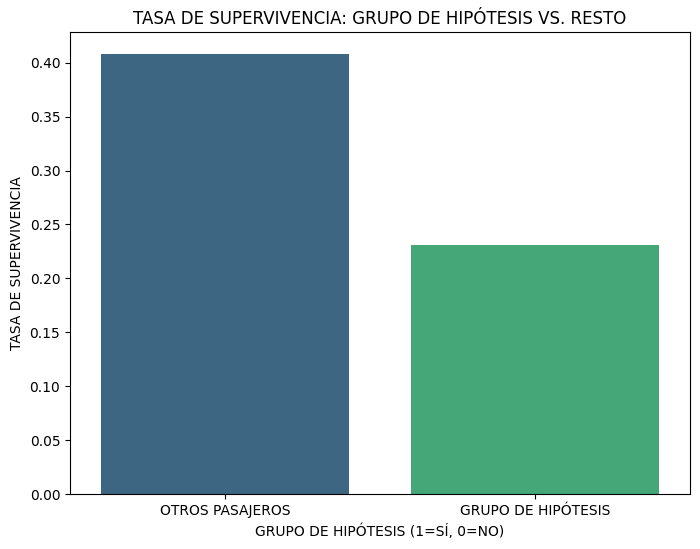

In [16]:
survival_rate_grupo = df.groupby('Hipotesis3_Interaction')['Survived'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(
    data=survival_rate_grupo,
    x='Hipotesis3_Interaction',
    y='Survived',
    palette='viridis'
)
plt.title('TASA DE SUPERVIVENCIA: GRUPO DE HIPÓTESIS VS. RESTO')
plt.xlabel('GRUPO DE HIPÓTESIS (1=SÍ, 0=NO)')
plt.ylabel('TASA DE SUPERVIVENCIA')
plt.xticks(ticks=[0, 1], labels=['OTROS PASAJEROS', 'GRUPO DE HIPÓTESIS'])
plt.show()

In [17]:
# Seleccionamos variables independientes y dependientes
vars_i = df[['Hipotesis3_Interaction', 'Age', 'Sex_male']]
var_d = df['Survived']
vars_i = sm.add_constant(vars_i)

try:
    modelo = sm.Logit(var_d, vars_i).fit()
    print("\n" + "="*50)
    print("RESUMEN DEL MODELO DE REGRESIÓN LOGÍSTICA")
    print("="*50)
    print(modelo.summary())

    # Interpretamos de resultados
    odds_ratio = np.exp(modelo.params['Hipotesis3_Interaction'])
    p_value = modelo.pvalues['Hipotesis3_Interaction']

    print(f"\nODDS RATIO PARA LA INTERACCIÓN DE LA HIPÓTESIS 3: {odds_ratio:.4f}")
    print(f"VALOR P PARA LA INTERACCIÓN DE LA HIPÓTESIS 3: {p_value:.4f}")

    if p_value < 0.05 and odds_ratio < 1.0:
        print("\nCONCLUSIÓN: LA HIPÓTESIS ES ESTADÍSTICAMENTE SIGNIFICATIVA Y ES APOYADA POR LOS DATOS.")
        print("LA POSIBILIDAD DE SUPERVIVENCIA DISMINUYE PARA ESTE GRUPO ESPECÍFICO.")
    else:
        print("\nCONCLUSIÓN: LA HIPÓTESIS NO ES ESTADÍSTICAMENTE SIGNIFICATIVA O NO SE CUMPLE.")
        print("EL VALOR P ES MAYOR A 0.05 O EL ODDS RATIO ES MAYOR A 1.")

except Exception as e:
    print(f"\nERROR AL AJUSTAR EL MODELO: {e}")

Optimization terminated successfully.
         Current function value: 0.487648
         Iterations 6

RESUMEN DEL MODELO DE REGRESIÓN LOGÍSTICA
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      887
Method:                           MLE   Df Model:                            3
Date:                Sat, 13 Sep 2025   Pseudo R-squ.:                  0.2677
Time:                        20:18:18   Log-Likelihood:                -434.49
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.493e-68
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.9020      0.

## Consideraciones de Sesgo y Ética

1. Sesgo de supervivencia

<Figure size 1200x600 with 0 Axes>

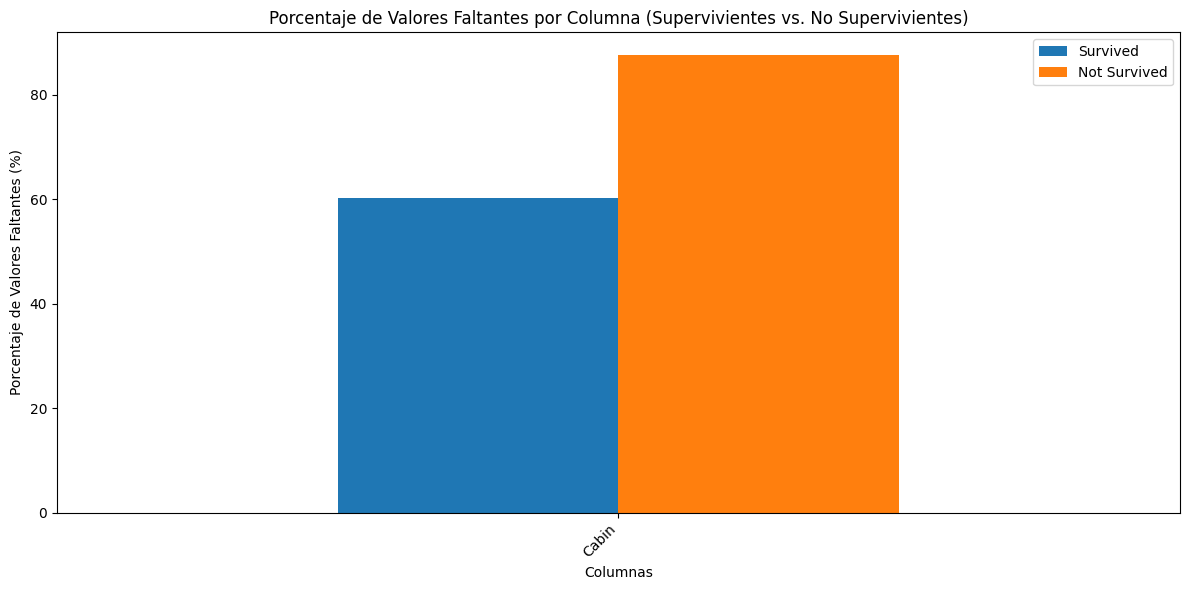

In [18]:
# Calcular el porcentaje de valores faltantes por columna para supervivientes y no supervivientes
missing_survived = df[df['Survived'] == 1].isnull().sum() / len(df[df['Survived'] == 1]) * 100
missing_not_survived = df[df['Survived'] == 0].isnull().sum() / len(df[df['Survived'] == 0]) * 100

# Crear un DataFrame para facilitar la visualización
missing_data = pd.DataFrame({'Survived': missing_survived, 'Not Survived': missing_not_survived})

# Eliminar filas donde no hay valores faltantes en ninguna de las categorías
missing_data = missing_data[(missing_data['Survived'] > 0) | (missing_data['Not Survived'] > 0)]

# Graficar
plt.figure(figsize=(12, 6))
missing_data.plot(kind='bar', figsize=(12, 6))
plt.title('Porcentaje de Valores Faltantes por Columna (Supervivientes vs. No Supervivientes)')
plt.xlabel('Columnas')
plt.ylabel('Porcentaje de Valores Faltantes (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Estrategia de mitigación sobre el sesgo de supervivencia: Análisis de sensibilidad

In [19]:
# Análisis de Sensibilidad para Mitigar el Sesgo de Supervivencia
# Estrategia: Imputar valores faltantes bajo diferentes supuestos y observar cómo afecta a los resultados clave.

# 1. Imputación Pessimista: Asumir que todos los pasajeros con cabina desconocida (NaN) NO sobrevivieron.
df_pessimist = df.copy()
df_pessimist['Cabin'].fillna('Unknown', inplace=True)
# Creamos una columna binaria para indicar si la cabina era desconocida
df_pessimist['CabinUnknown'] = (df_pessimist['Cabin'] == 'Unknown').astype(int)
# Asignamos 0 a 'Survived' para los que tenían 'CabinUnknown' (solo si 'Survived' no es nulo originalmente)
df_pessimist.loc[df_pessimist['CabinUnknown'] == 1, 'Survived_Pessimist'] = 0
# Para el resto, usamos el valor original de 'Survived'
df_pessimist.loc[df_pessimist['CabinUnknown'] == 0, 'Survived_Pessimist'] = df_pessimist['Survived']

print("\n--- Análisis de Sensibilidad (Imputación Pessimista) ---")
print("Tasa de supervivencia con imputación pesimista:", df_pessimist['Survived_Pessimist'].mean())

# 2. Imputación Optimista: Asumir que todos los pasajeros con cabina desconocida (NaN) SÍ sobrevivieron.
df_optimist = df.copy()
df_optimist['Cabin'].fillna('Unknown', inplace=True)
df_optimist['CabinUnknown'] = (df_optimist['Cabin'] == 'Unknown').astype(int)
# Asignamos 1 a 'Survived' para los que tenían 'CabinUnknown'
df_optimist.loc[df_optimist['CabinUnknown'] == 1, 'Survived_Optimist'] = 1
# Para el resto, usamos el valor original de 'Survived'
df_optimist.loc[df_optimist['CabinUnknown'] == 0, 'Survived_Optimist'] = df_optimist['Survived']

print("\n--- Análisis de Sensibilidad (Imputación Optimista) ---")
print("Tasa de supervivencia con imputación optimista:", df_optimist['Survived_Optimist'].mean())

# 3. Comparación con la tasa de supervivencia original
print("\n--- Comparación ---")
print("Tasa de supervivencia original:", df['Survived'].mean())

# Interpretación: La diferencia en las tasas de supervivencia bajo los escenarios optimista y pesimista
# indica la sensibilidad de los resultados a la forma en que se tratan los valores faltantes en la cabina.
# Si la diferencia es grande, el sesgo por datos faltantes en la cabina es significativo.


--- Análisis de Sensibilidad (Imputación Pessimista) ---
Tasa de supervivencia con imputación pesimista: 0.1526374859708193

--- Análisis de Sensibilidad (Imputación Optimista) ---
Tasa de supervivencia con imputación optimista: 0.9236812570145904

--- Comparación ---
Tasa de supervivencia original: 0.3838383838383838


/var/folders/0l/1v0zpypj6wj_fr86w3yq14x00000gn/T/ipykernel_29885/1643693388.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pessimist['Cabin'].fillna('Unknown', inplace=True)
/var/folders/0l/1v0zpypj6wj_fr86w3yq14x00000gn/T/ipykernel_29885/1643693388.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [20]:
# Calcular el porcentaje de valores faltantes por columna para cada clase social
missing_pclass1 = df[df['Pclass'] == 1].isnull().sum() / len(df[df['Pclass'] == 1]) * 100
missing_pclass2 = df[df['Pclass'] == 2].isnull().sum() / len(df[df['Pclass'] == 2]) * 100
missing_pclass3 = df[df['Pclass'] == 3].isnull().sum() / len(df[df['Pclass'] == 3]) * 100


# Crear un DataFrame para facilitar la visualización
missing_data_pclass = pd.DataFrame({'Pclass 1': missing_pclass1, 'Pclass 2': missing_pclass2, 'Pclass 3': missing_pclass3})

# Eliminar filas donde no hay valores faltantes en ninguna de las categorías
missing_data_pclass = missing_data_pclass[(missing_data_pclass['Pclass 1'] > 0) | (missing_data_pclass['Pclass 2'] > 0) | (missing_data_pclass['Pclass 3'] > 0)]

# Graficar
plt.figure(figsize=(12, 6))
missing_data_pclass.plot(kind='bar', figsize=(12, 6))
plt.title('Porcentaje de Valores Faltantes por Columna (Por Clase Social)')
plt.xlabel('Columnas')
plt.ylabel('Porcentaje de Valores Faltantes (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

KeyError: 'Pclass'

In [ ]:
# Calcular el porcentaje de valores faltantes por columna por género
missing_men = df[df['Sex'] == 'male'].isnull().sum() / len(df[df['Sex'] == 'male']) * 100
missing_women = df[df['Sex'] == 'female'].isnull().sum() / len(df[df['Sex'] == 'female']) * 100


# Crear un DataFrame para facilitar la visualización
missing_data_gender = pd.DataFrame({'Men': missing_men, 'Women': missing_women})

# Eliminar filas donde no hay valores faltantes en ninguna de las categorías
missing_data_gender = missing_data_gender[(missing_data_gender['Men'] > 0) | (missing_data_gender['Women'] > 0)]

# Graficar
plt.figure(figsize=(12, 6))
missing_data_gender.plot(kind='bar', figsize=(12, 6))
plt.title('Porcentaje de Valores Faltantes por Columna (Por sexo)')
plt.xlabel('Columnas')
plt.ylabel('Porcentaje de Valores Faltantes (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2. Sesgo Histórico y Grupos Subrepresentados

Es crucial considerar si existen sesgos históricos inherentes al evento del Titanic que puedan verse reflejados en el dataset, lo que podría llevar a la subrepresentación de ciertos grupos entre los supervivientes o incluso en los datos disponibles.

**Posibles áreas de Sesgo Histórico:**

*   **Clase Social:** Históricamente, los pasajeros de clases más bajas a menudo tuvieron menos acceso a botes salvavidas y peores condiciones de viaje. Esto podría significar una subrepresentación de las clases bajas entre los supervivientes.
*   **Género:** Las políticas de "mujeres y niños primero" influyeron significativamente en las tasas de supervivencia, lo que resultó en una mayor proporción de mujeres y niños entre los supervivientes en comparación con los hombres adultos.
*   **Edad:** Similar al género, los niños fueron priorizados, lo que podría llevar a una subrepresentación de adultos jóvenes y de mediana edad entre los supervivientes.
*   **Origen/Puerto de Embarque:** Las condiciones y la organización del embarque en los diferentes puertos (Southampton, Cherbourg, Queenstown) podrían haber afectado a diferentes grupos de pasajeros de manera desigual.

**Análisis en el Dataset:**

Para investigar esto en nuestro dataset, podemos analizar la distribución de los pasajeros por clase social, género y edad, y comparar estas distribuciones con las tasas de supervivencia.

**Próximos Pasos para Identificar Sesgo:**

Podemos generar visualizaciones y estadísticas para explorar la composición del dataset en términos de estas características demográficas y observar cómo se distribuye la supervivencia dentro de estos grupos. Por ejemplo:

*   Gráficos de barras que muestren el número de pasajeros por clase, género y grupo de edad.
*   Comparación de las tasas de supervivencia por clase, género y grupo de edad.
*   Análisis combinado de factores, como la supervivencia por género dentro de cada clase.

Este análisis nos ayudará a identificar qué grupos podrían haber estado en desventaja histórica y si esa desventaja se refleja en su representación en el conjunto de datos de supervivientes.

# Tratamiento de datos faltantes

WIP local de Omar

# Tratamiento de datos faltantes

Hay solamente 3 columnas con valores faltantes en el dataset:



1.   Edad (`Age`)
2.   Cabina (`Cabin`)
3.   Puerto de embarcación (`Cabin`)



In [ ]:
df = pd.read_csv("Titanic-Dataset.csv") # vuelvo a cargar los datos, porque fueron rellenados en analisis anteriores.
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['Fare_bin'] = pd.qcut(df['Fare'], 4, labels=["Q1","Q2","Q3","Q4"])

# Crear indicadores de valores faltantes
df['Age_missing'] = df['Age'].isnull().astype(int)
df['Cabin_missing'] = df['Cabin'].isnull().astype(int)
df['Embarked_missing'] = df['Embarked'].isnull().astype(int)

df.columns[df.isna().any()]


## Missingness de puerto de embarcación (`Embarked`)

Embarked es la unica columna en la que menos de 10 valores falta. En total, solo faltan 2 valores, ambos en primera clase:

In [ ]:
df[df['Embarked'].isnull() == True]

Las dos mujeres sin la indicación del puerto en el que subieron comparten el mismo numero de ticket (en primera clase), ambas sobrevivieron, y estaban en la misma cabina.

Es difícil decir si hay relación entre el valor faltante y las demás variables, pues más allá de estas coincidencias parece que no había un parentezco o relación entre ellas.
*   No comparten apellidos
*   No indican tener parientes abordo

Son las unicas dos personas en la cabina B28, así que nuestra mejor teoría es que no se registró

Para esta variable concluimos que es **completamente aleatoria**, pero por el tamaño de muestra tan pequeño, es practicamente imposible hacer un análisis estadístico más profundo con significancia.

#### Imputación

Al ser una muestra tan pequeña, usar la moda entre los pasajeros de primera clase, Southampton, es razonable, y no debería de lastimar ningún análisis que asuma así el dato. Dicho eso, solamente 2 pasajeros no tienen este dato, puede que sea mejor simplemente eliminarlos de la muestra cuando sea de importancia el puerto.

## Missingness de Cabin

### Patrón de missingess

La falta de los valores de Cabin es bastante notorio, e incluso al primer vistazo es aparente que no es **completamente** aleatorio, sino que está fuertemente correlacionado a la clase de boleto y su costo, pero sin ser basado en el valor mismo de la columna. **(MAR)**

### Evidencia Estadística

Hay multiples correlaciones que se exploraron para llegar a esta conclusión, empezando por la evidente correlación a la clase de boleto, seguido de la supervivencia, la tarifa pagada, y el tamaño de la familia.

In [ ]:
df['Cabin_missing'] = df['Cabin'].isnull().astype(int)

pivot_cabin_class = df.groupby("Pclass")["Cabin_missing"].mean() * 100
pivot_cabin_surv = df.groupby("Survived")["Cabin_missing"].mean() * 100
pivot_cabin_fare = df.groupby("Fare_bin")["Cabin_missing"].mean() * 100
pivot_cabin_family = df.groupby("FamilySize")["Cabin_missing"].mean() * 100

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Por Clase
pivot_cabin_class.plot(kind="bar", color="steelblue", ax=axes[0,0])
axes[0,0].set_title("Porcentaje de Cabina Faltantes por Clase")
axes[0,0].set_ylabel("% Faltante")
axes[0,0].set_xlabel("Clase (Pclass)")

# Por Supervivencia
pivot_cabin_surv.plot(kind="bar", color="orange", ax=axes[0,1])
axes[0,1].set_title("Porcentaje de Cabina Faltantes por Supervivencia")
axes[0,1].set_ylabel("% Faltante")
axes[0,1].set_xlabel("Supervivencia (0=No, 1=Sí)")

# Por Cuartiles de Tarifa
pivot_cabin_fare.plot(kind="bar", color="green", ax=axes[1,0])
axes[1,0].set_title("Porcentaje de Cabina Faltantes por Cuartiles de Tarifa")
axes[1,0].set_ylabel("% Faltante")
axes[1,0].set_xlabel("Cuartil de Tarifa")

# Por Tamaño de Familia
pivot_cabin_family.plot(kind="bar", color="purple", ax=axes[1,1])
axes[1,1].set_title("Porcentaje de Cabina Faltantes por Tamaño de Familia")
axes[1,1].set_ylabel("% Faltante")
axes[1,1].set_xlabel("Tamaño de Familia")

plt.tight_layout()
plt.show()

Observando el porcentaje de cada clase que no tiene registrada la cabina, es claro que en general no era una prioridad mantener el registro de las cabinas de los pasajeros, pues incluso en primera clase (`Pclass == 1`), 18.5% de los pasajeros no tenian registrada la cabina en la que se hospedaban. Dicho esto, esa es la mayor correlación que se presenta en el dataset.

In [ ]:
pivot_cabin_class

La otra variable que parece tener una tendencia es la del tamaño de familia. En este caso, ninguna de las familias grandes a bordo del Titanic tenían registrada una cabina.
Entre esas familias grandes estan algunas como:

* Familia Sage (11 personas)
* Familia Goodwin (8 personas)
* Familia Andersson (7 personas)
* Familia Asplund (7 personas)
* Familia Rice (6 personas)
* Familia Panula (6 personas)

Todas estas familias viajaban en tercera clase, lo que nos regresa a nuestra más grande correlación, que puede que haya sido exacerbada por el tamaño de la familia, y la logística de acomodarlos a todos dentro del barco.

### Casos completos vs. incompletos

La clase de boleto hace la diferencia más marcada, y apunta a un elemento sistemático en la falta de registro de las cabinas. Pero es necesario hacer un anális estadístico que lo demuestre.

In [ ]:
# tabla de contingencia
contingency = pd.crosstab(df['Pclass'], df['Cabin_missing'])

# Chi cuadrado
chi2, p, dof, expected = stats.chi2_contingency(contingency)

print("Chi-cuadrado para Cabin_missing vs Pclass")
print("Chi2 =", chi2, "p-value =", p)

El valor de *p* es tan bajo que es indudable que la diferencia es significativa.

Algunas de las variables parecen indicar correlación también, como la tarifa o la supervivencia, pero solo son un reflejo de la correlación por clase.

In [ ]:
survival_all = df['Survived'].value_counts(normalize=True) * 100
survival_missing = df.loc[df['Cabin_missing']==1, 'Survived'].value_counts(normalize=True) * 100

fare_all = df['Fare'].dropna()
fare_missing = df.loc[df['Cabin_missing']==1, 'Fare'].dropna()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Gráfico 1: Supervivencia (todos los pasajeros)
survival_all.plot(kind="bar", color="steelblue", ax=axes[0,0])
axes[0,0].set_title("Distribución de Supervivencia (Todos los Pasajeros)")
axes[0,0].set_ylabel("% de Pasajeros")
axes[0,0].set_xlabel("Supervivencia (0=No, 1=Sí)")
axes[0,0].set_ylim(0, 100)

# Gráfico 2: Supervivencia (solo Cabin faltante)
survival_missing.plot(kind="bar", color="orange", ax=axes[0,1])
axes[0,1].set_title("Distribución de Supervivencia (Solo Cabin Faltante)")
axes[0,1].set_ylabel("% de Pasajeros")
axes[0,1].set_xlabel("Supervivencia (0=No, 1=Sí)")
axes[0,1].set_ylim(0, 100)

# Gráfico 3: Histograma de Tarifa (todos los pasajeros)
axes[1,0].hist(fare_all, bins=10, color="green", alpha=0.7)
axes[1,0].set_title("Distribución de Tarifa (Todos los Pasajeros)")
axes[1,0].set_xlabel("Tarifa")
axes[1,0].set_ylabel("Frecuencia")
axes[1,0].set_ylim(0, 700)

# Gráfico 4: Histograma de Tarifa (solo Cabin faltante)
axes[1,1].hist(fare_missing, bins=10, color="purple", alpha=0.7)
axes[1,1].set_title("Distribución de Tarifa (Solo Cabin Faltante)")
axes[1,1].set_xlabel("Tarifa")
axes[1,1].set_ylabel("Frecuencia")
axes[1,1].set_ylim(0, 700)

plt.tight_layout()
plt.show()

In [ ]:
# tabla de contingencia
contingency = pd.crosstab(df['Pclass'], df['Cabin_missing'])

# Chi cuadrado
chi2, p, dof, expected = stats.chi2_contingency(contingency)

print("Chi-cuadrado para Cabin_missing vs Pclass")
print("Chi2 =", chi2, "p-value =", p)

### Correlación

La matriz de correlación deja esto aún más claro. La mayor correlación con la falta del registro de la cabina se encuentra con la clase del boleto, y ninguna otra correlación moderadamente fuerte se encuentra, más allá de la de la tarifa. Sin embargo, en la exploración inicial del dataset ya se sabía que la tarifa y la clase del boleto van mano en mano.

In [ ]:
# variables para la matriz de correlación
corr_vars = [
    'Cabin_missing', 'Pclass', 'Fare', 'Survived', 'FamilySize',
    'Age_missing', 'Embarked_missing'
]

# Calcular matriz de correlación
metodo = 'Pearson' # Parece que Pearson es apropiado para este caso, pero los demas mostraban resultados similares
corr_matrix = df[corr_vars].corr(method=metodo.lower())

# Graficar heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title(f"Matriz de Correlación ({metodo}) entre variables y valores Faltantes")
plt.show()

## Missingess de Age

Comparado a la cabina, el registro de la edad es mucho mas extenso, aunque sigue presentando una tendencia a que aquellos en tercera clase eran menos propensos a registrarse.

In [ ]:
pivot_age = pd.pivot_table(df, values="Age_missing", index="Pclass", aggfunc=["mean", "sum"])
pivot_age

In [ ]:
pivot_age_class = df.groupby("Pclass")["Age_missing"].mean() * 100
pivot_age_surv = df.groupby("Survived")["Age_missing"].mean() * 100
pivot_age_fare = df.groupby("Fare_bin")["Age_missing"].mean() * 100
pivot_age_family = df.groupby("FamilySize")["Age_missing"].mean() * 100

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Por Clase
pivot_age_class.plot(kind="bar", color="steelblue", ax=axes[0,0])
axes[0,0].set_title("Porcentaje de Edad faltante por Clase")
axes[0,0].set_ylabel("% Faltante")
axes[0,0].set_xlabel("Clase (Pclass)")

# Por Supervivencia
pivot_age_surv.plot(kind="bar", color="orange", ax=axes[0,1])
axes[0,1].set_title("Porcentaje de Edad faltante por Supervivencia")
axes[0,1].set_ylabel("% Faltante")
axes[0,1].set_xlabel("Supervivencia (0=No, 1=Sí)")

# Por Cuartiles de Tarifa
pivot_age_fare.plot(kind="bar", color="green", ax=axes[1,0])
axes[1,0].set_title("Porcentaje de Edad faltante por Cuartiles de Tarifa")
axes[1,0].set_ylabel("% Faltante")
axes[1,0].set_xlabel("Cuartil de Tarifa")

# Por Tamaño de Familia
pivot_age_family.plot(kind="bar", color="purple", ax=axes[1,1])
axes[1,1].set_title("Porcentaje de Edad faltante por Tamaño de Familia")
axes[1,1].set_ylabel("% Faltante")
axes[1,1].set_xlabel("Tamaño de Familia")

plt.tight_layout()
plt.show()

Una vez más el tamaño de familia se puede considerar un outlier, siendo que la familia Sage tampoco registró la edad de ninguno de los miembros de la familia. Dicho eso, es sorprendente que las otras grandes familias como la Andersson o Asplund registraron la edad de todos los miembros, desde los bebés de 1 o 2 años hasta las cabezas de la familia.

Aunque la relación no es tan clara como en el caso de las cabinas, se sigue pudiendo demostrar que el registro de la edad está relacionado a clase, como lo demuestra esta prueba de Chi cuadrado:

In [ ]:
contingency = pd.crosstab(df['Pclass'], df['Age_missing'])

chi2, p, dof, expected = stats.chi2_contingency(contingency)

print("Chi-cuadrado para Age_missing vs Pclass")
print("Chi2 =", chi2, "p-value =", p)

observado = contingency.values
esperado = expected.astype(int)
contingency

In [ ]:
pd.DataFrame(esperado, index=contingency.index, columns=contingency.columns)

Esto nos lleva a la conclusión de que no es independiente la falta de valores de edad, aún si no es una relación lineal. En específico, la primera y *sobre todo* la segunda clase tienen menos valores faltantes de lo esperado, mientras que la tercera clase tiene bastantes valores faltantes más de lo esperado.

### Matriz de correlación

In [ ]:
corr_vars = [
    'Age_missing', 'Pclass', 'SibSp', 'Cabin_missing', 'Embarked_missing',
    'Survived', 'Fare', 'FamilySize', 'Parch'
]

metodo = 'Spearman' # Ningun metodo muestra una fuerte correlación en la matriz
corr_matrix = df[corr_vars].corr(method=metodo.lower())

# Graficar heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title(f"Matriz de Correlación ({metodo}) entre variables y valores Faltantes")
plt.show()

# Estrategias de Imputación

Para la edad y el puerto de embarcación exploramos 3 métodos de imputación de los datos faltantes. Esto no es posible para la cabina, pues no es una variable ni discreta ni categórica. De la misma manera que no podríamos rellenar nombres que faltaran, no se puede rellenar por medio de estadística el nombre dado a las cabinas, que claramente tienen un sistema para su nombre que desconocemos.

In [ ]:
df["Cabin"].dropna().head()

### Método simple

Para el puerto de embarcación, la forma más simple de rellenar los dos datos faltantes es la moda del dataset completo, **Southampton**.

In [ ]:
df["Embarked"].mode()

Para la edad, podemos tomar la mediana, para no dejar que la cola grande a la derecha deforme la representación real de los datos. Esta cola la vimos en la exploración inicial de los datos.

In [ ]:
print("Promedio:", df['Age'].dropna().mean())
print("Mediana:", df['Age'].dropna().median())

Realmente son muy similares, pero es más apropiado para la forma de los datos.

### Método basado en grupos

La imputación por grupos nos permite rellenar con valores seleccionados más inteligentemente, basándonos en el demográfico específico que queremos rellenar. Lamentablemente, no es tan sencillo encontrar diferencias significantes segmentando en grupos

Para el puerto en el que se embarca, podemos tomar la moda de cada clase, pero somos conscientes de que al solo faltar dos datos, en la misma clase, esto no hace mucha diferencia.

In [ ]:
group = df.groupby("Pclass")["Embarked"]
group.value_counts()

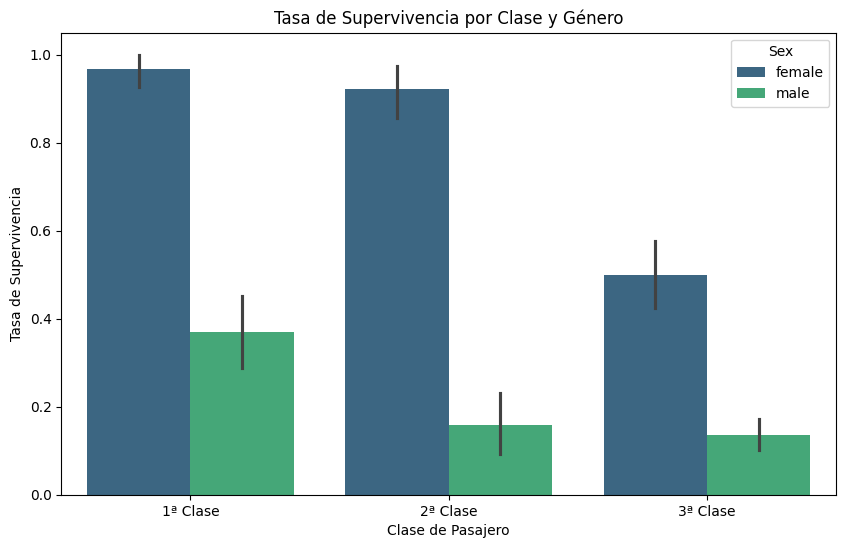

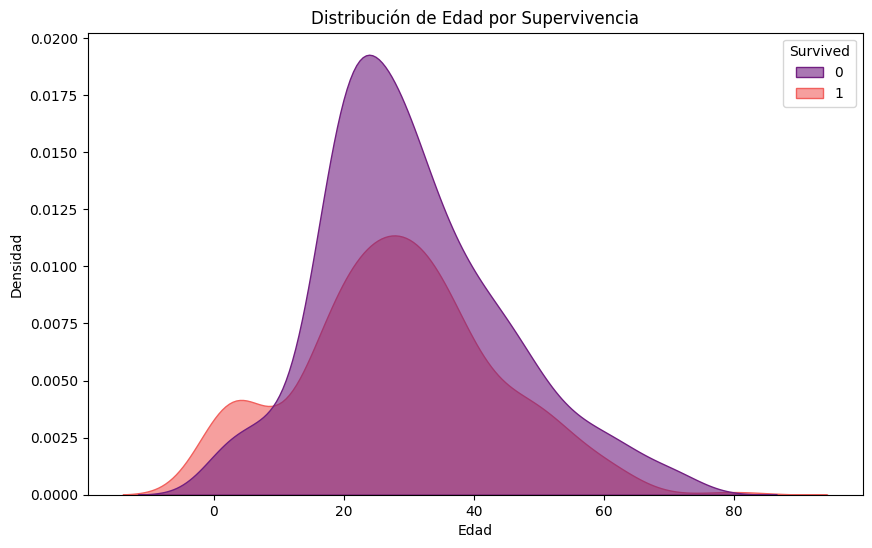

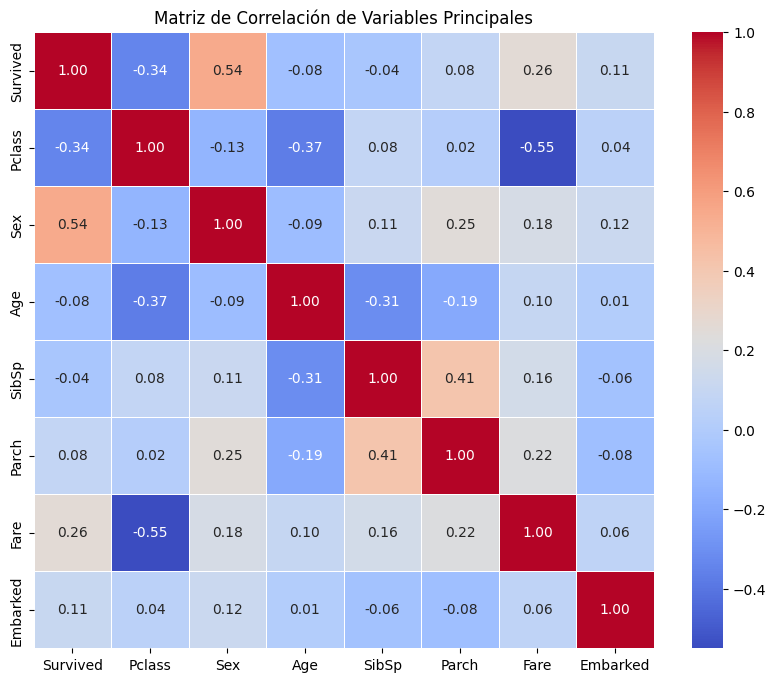

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/raw/Titanic-Dataset.csv")


# --- Figura 1: Supervivencia por Clase y Género ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x='Pclass',
    y='Survived',
    hue='Sex',
    palette='viridis'
)
plt.title('Tasa de Supervivencia por Clase y Género')
plt.xlabel('Clase de Pasajero')
plt.ylabel('Tasa de Supervivencia')
plt.xticks(ticks=[0, 1, 2], labels=['1ª Clase', '2ª Clase', '3ª Clase'])
plt.show()

# --- Figura 2: Distribución de Edad por Supervivencia ---
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df,
    x='Age',
    hue='Survived',
    fill=True,
    palette='magma',
    alpha=0.6
)
plt.title('Distribución de Edad por Supervivencia')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.show()

# --- Figura 3: Correlación entre Features Principales ---
# Es necesario crear las variables dummy de nuevo para un análisis de correlación completo.
df_corr = df.copy()
df_corr['Sex'] = df_corr['Sex'].map({'male': 0, 'female': 1})
df_corr['Embarked'] = df_corr['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Calcula la matriz de correlación
matriz_correlacion = df_corr[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    matriz_correlacion,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5
)
plt.title('Matriz de Correlación de Variables Principales')
plt.show()